In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

np.random.seed(0)
torch.manual_seed(0)

In [2]:
hts_df = pd.read_csv('hts_example.csv', index_col=None)

latent_dims = []
input_dim = 0
hidden_dim = 512
N = 10

for column in hts_df.columns:
    print(f'Attribute Type = {column}')
    print(f'Num of Categories in Attribute = {hts_df[column].nunique()}')
    latent_dims.append([N, hts_df[column].nunique()])
    input_dim += hts_df[column].nunique()

Attribute Type = start_type
Num of Categories in Attribute = 5
Attribute Type = act_num
Num of Categories in Attribute = 9
Attribute Type = mode_num
Num of Categories in Attribute = 9
Attribute Type = end_type
Num of Categories in Attribute = 5


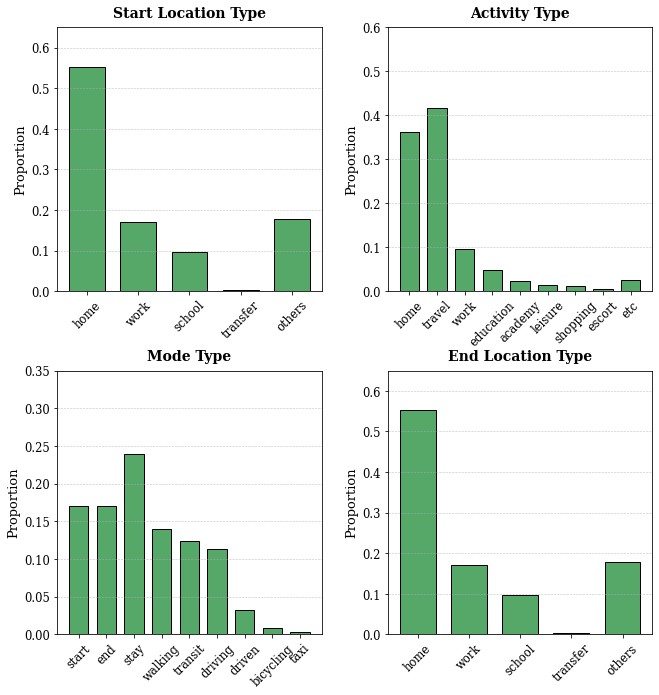

In [12]:
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(h_pad=6, w_pad=3.5)

attribute_list = ['start_type', 'act_num', 'mode_num', 'end_type']
title_list = ['Start Location Type', 'Activity Type', 'Mode Type', 'End Location Type']
location_list = ['home', 'work', 'school', 'transfer', 'others']
act_list = ['home', 'travel', 'work', 'education', 'academy', 'leisure', 'shopping', 'escort', 'etc']
mode_list = ['start', 'end', 'stay', 'walking', 'transit', 'driving', 'driven', 'bicycling', 'taxi']
axis_list = [location_list, act_list, mode_list, location_list]
ylim_list = [0.65, 0.6, 0.35, 0.65]

for (N, K), name, title, axis, ylim, ax in zip(latent_dims, attribute_list, title_list, axis_list, ylim_list, axs.flatten()):

    unique, counts = np.unique(hts_df[name].values, return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#55A868', edgecolor='black', width=0.7)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(np.arange(K))
    ax.tick_params(axis='both', which='major', labelsize=11.5)
    ax.set_xticklabels(axis, rotation=45)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    ax.set_ylabel('Proportion', fontsize=13)

plt.savefig(f'hts_real.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [4]:
encoder = OneHotEncoder(sparse=False)
one_hot_data = encoder.fit_transform(hts_df.values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loader = DataLoader(one_hot_data, batch_size=250, shuffle=True)

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dims):
        super().__init__()
        self.latent_dims = latent_dims
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, sum(N * K for N, K in latent_dims))

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        logits = self.fc3(h)
        return logits

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)        
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

class CategoricalVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dims):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dims)
        self.decoder = Decoder(sum(N * K for N, K in latent_dims), hidden_dim, input_dim)
        self.latent_dims = latent_dims

    def forward(self, x, temperature=1.0):
        logits = self.encoder(x)
        z_list = []
        start = 0
        for N, K in self.latent_dims:
            end = start + N * K
            z_list.append(gumbel_softmax(logits[:, start:end].reshape(-1, N, K), temperature, batch=True))
            start = end
        
        z = torch.cat([z.reshape(z.size(0), -1) for z in z_list], dim=1) 
        return logits, self.decoder(z)

def loss_function(recon_x, x, logits, latent_dims):
    BCE = 0
    start_x = 0
    start_logits = 0
    for i, (N, K) in enumerate(latent_dims):
        end_x = start_x + K
        end_logits = start_logits + N * K
        BCE += F.cross_entropy(recon_x[:, start_x:end_x], torch.argmax(x[:, start_x:end_x], dim=1).to(recon_x.device), reduction='sum')
        start_x = end_x
        start_logits = end_logits
        
    KLD = categorical_kl_divergence(logits.view(logits.shape[0], -1, latent_dims[0][1])).sum()     
    return BCE + KLD

In [6]:
def gumbel_distribution_sample(shape: torch.Size, eps=1e-20) -> torch.Tensor:
    """Samples from the Gumbel distribution given a tensor shape and value of epsilon."""
    U = torch.rand(shape, device=shape[0].device if isinstance(shape[0], torch.Tensor) else 'cpu')
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_distribution_sample(logits: torch.Tensor, temperature: float) -> torch.Tensor:
    """Adds Gumbel noise to `logits` and applies softmax along the last dimension."""
    y = logits + torch.tensor(gumbel_distribution_sample(logits.shape), dtype=torch.float32).to(device)
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits: torch.Tensor, temperature: float, batch=False) -> torch.Tensor:

    input_shape = logits.shape
    if batch:
        assert len(input_shape) == 3, "Batch input should be 3D: [batch_size, n_distributions, n_classes]"
        b, n, k = input_shape
        logits = logits.reshape(b*n, k)
    else:
        assert len(input_shape) == 2, "Non-batch input should be 2D: [n_distributions, n_classes]"
    
    y = gumbel_softmax_distribution_sample(logits, temperature)    
    return y.reshape(input_shape)

def categorical_kl_divergence(logits: torch.Tensor) -> torch.Tensor:

    B, N, K = logits.shape
    
    # Compute log probabilities
    log_probs = F.log_softmax(logits, dim=-1)
    
    # Compute probabilities
    probs = torch.exp(log_probs)
    
    # Uniform prior
    uniform_prior = torch.full_like(probs, 1.0 / K)
    
    # KL divergence
    kl_div = torch.sum(probs * (log_probs - torch.log(uniform_prior)), dim=-1)
    
    return kl_div

In [7]:
learning_rate = 0.001

model = CategoricalVAE(input_dim, hidden_dim, latent_dims).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

In [8]:
num_epochs = 34
initial_temperature = 1.0
min_temperature = 0.5
anneal_rate = 0.00003

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        x = batch
        
        # Forward pass
        temperature = max(initial_temperature * np.exp(-anneal_rate * epoch), min_temperature)
        logits, x_recon = model(torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(temperature, dtype=torch.float32).to(device))
        
        # Compute loss
        loss = loss_function(x_recon, x, logits, latent_dims)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        total_loss += loss.item()
    
    # Print epoch results
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Temperature: {temperature:.4f}")

print("Training completed!")

<ipython-input-8-e05b55468e8a>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits, x_recon = model(torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(temperature, dtype=torch.float32).to(device))
<ipython-input-6-4a161fe48ee4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = logits + torch.tensor(gumbel_distribution_sample(logits.shape), dtype=torch.float32).to(device)


Epoch [1/34], Average Loss: 403.3850, Temperature: 1.0000
Epoch [2/34], Average Loss: 88.1690, Temperature: 1.0000
Epoch [3/34], Average Loss: 33.8287, Temperature: 0.9999
Epoch [4/34], Average Loss: 18.4712, Temperature: 0.9999
Epoch [5/34], Average Loss: 11.7753, Temperature: 0.9999
Epoch [6/34], Average Loss: 9.0994, Temperature: 0.9999
Epoch [7/34], Average Loss: 6.4689, Temperature: 0.9998
Epoch [8/34], Average Loss: 5.8450, Temperature: 0.9998
Epoch [9/34], Average Loss: 5.6453, Temperature: 0.9998
Epoch [10/34], Average Loss: 5.4085, Temperature: 0.9997
Epoch [11/34], Average Loss: 4.6292, Temperature: 0.9997
Epoch [12/34], Average Loss: 4.0377, Temperature: 0.9997
Epoch [13/34], Average Loss: 3.8273, Temperature: 0.9996
Epoch [14/34], Average Loss: 3.1115, Temperature: 0.9996
Epoch [15/34], Average Loss: 3.2881, Temperature: 0.9996
Epoch [16/34], Average Loss: 3.6710, Temperature: 0.9996
Epoch [17/34], Average Loss: 3.0336, Temperature: 0.9995
Epoch [18/34], Average Loss: 2.710

In [23]:
torch.save(model.state_dict(), 'models/vae_discrete.pth')

In [9]:
def sample_latent(batch_size, latent_dims, device):
    z_samples = []
    for N, K in latent_dims:
        # Sample from a uniform categorical distribution
        z = torch.randint(0, K, (batch_size, N), device=device)
        # Convert to one-hot
        z_one_hot = F.one_hot(z, num_classes=K).float()
        z_samples.append(z_one_hot.view(batch_size, -1))
    return torch.cat(z_samples, dim=1)

def generate_samples(model, num_samples, latent_dims, device):
    model.eval() 
    with torch.no_grad():
        # Sample from the latent space
        z = sample_latent(num_samples, latent_dims, device)
        samples = model.decoder(z)
        
    return samples

num_samples = 3000  # Number of samples to generate
samples = generate_samples(model, num_samples, latent_dims, device)

samples = samples.cpu().numpy()  # Move to CPU and convert to numpy array

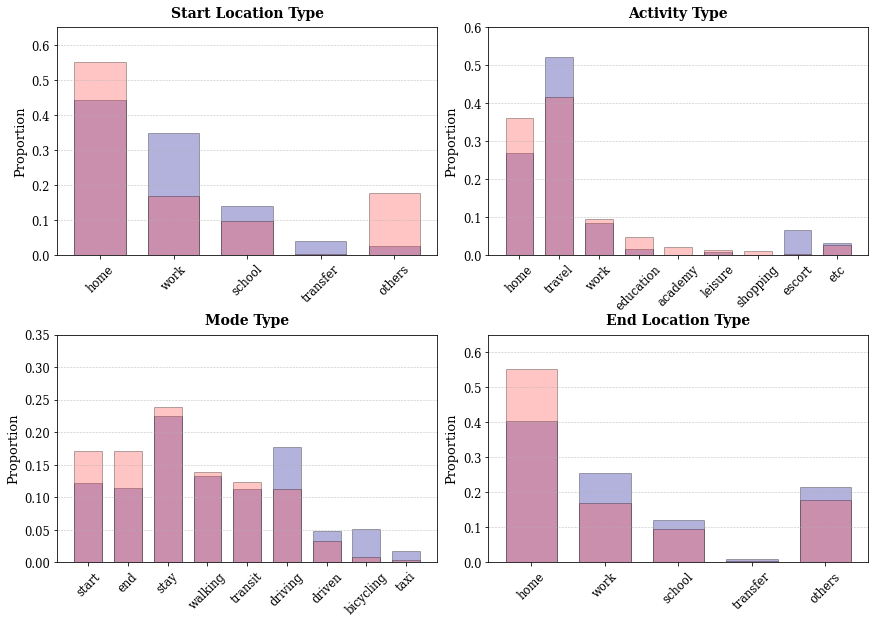

In [22]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(h_pad=6, w_pad=2)

attribute_list = ['start_type', 'act_num', 'mode_num', 'end_type']
title_list = ['Start Location Type', 'Activity Type', 'Mode Type', 'End Location Type']
location_list = ['home', 'work', 'school', 'transfer', 'others']
act_list = ['home', 'travel', 'work', 'education', 'academy', 'leisure', 'shopping', 'escort', 'etc']
mode_list = ['start', 'end', 'stay', 'walking', 'transit', 'driving', 'driven', 'bicycling', 'taxi']
axis_list = [location_list, act_list, mode_list, location_list]
ylim_list = [0.65, 0.6, 0.35, 0.65]

start = 0

for (N, K), name, title, axis, ylim, ax in zip(latent_dims, attribute_list, title_list, axis_list, ylim_list, axs.flatten()):

    end = start + K
    types = np.argmax(samples[:, start:end], axis=1)
    unique, counts = np.unique(types, return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#00008F', edgecolor='black', width=0.7, alpha=0.3)
    
    unique, counts = np.unique(hts_df[name].values, return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#FF4040', edgecolor='black', width=0.7, alpha=0.3)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(np.arange(K))
    ax.tick_params(axis='both', which='major', labelsize=11.5)
    ax.set_xticklabels(axis, rotation=45)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    ax.set_ylabel('Proportion', fontsize=13)
    start = end

plt.savefig(f'vae_discrete.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()